In [1]:
%pylab inline
import radvel
import radvel.likelihood

import corner
import copy

from scipy import optimize
rc('savefig',dpi=120)

# Convenient function for plotting fits
def plot_results(like):
    fig = gcf()
    errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    plot(ti, like.model(ti))
    xlabel('Time')
    ylabel('RV')
    draw()

Populating the interactive namespace from numpy and matplotlib


Intialize Keplerian model parameters
====================================

In [2]:
params = radvel.Parameters(1,basis='per tc secosw sesinw k')
params['k1'] = radvel.Parameter(value=1)
params['per1'] = radvel.Parameter(value=1)
params['secosw1'] = radvel.Parameter(value=0.1)
params['sesinw1'] = radvel.Parameter(value=+0.2)
params['tc1'] = radvel.Parameter(value=0.)
rv_mod = radvel.RVModel(params)

Generate Synthetic Data
=======================

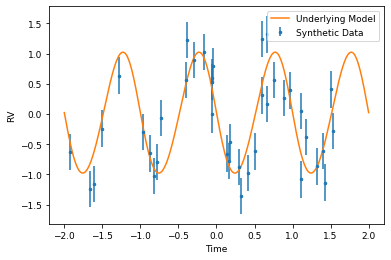

In [3]:
t = np.random.random_sample(40)
t = t * 4 - 2
t = np.sort(t)
ti = np.linspace(-2,2,400)
errvel = 0.3
jitter = 0.3
syn_rv = rv_mod(t) + randn(t.size)*np.sqrt(errvel**2 + jitter**2)
errorbar(t,syn_rv,yerr=errvel,fmt='.',label='Synthetic Data')
plot(ti,rv_mod(ti),label='Underlying Model')
xlabel('Time')
ylabel('RV')
legend()

Generate a likelihood
=====================

In [4]:
like_syn = radvel.likelihood.RVLikelihood(rv_mod,t,syn_rv,zeros(t.size)+errvel)
like_syn.params['gamma'] = radvel.Parameter(value=0)
like_syn.params['jit'] = radvel.Parameter(value=errvel)

truths = copy.deepcopy(like_syn.params) # Store away model parameters for later reference
like_syn.params.update(dict(k1=radvel.Parameter(value=3),
                            secosw1=radvel.Parameter(value=0.1),
                            sesinw1=radvel.Parameter(value=0.1),
                            tc1=radvel.Parameter(value=0.1))) # perturb the starting guess

like_syn.params['jit'].vary = False # Don't vary jitter


Perform a maximum likelihood fit
===============================

 final_simplex: (array([[ 0.99416136, -0.0340701 ,  0.19971382,  0.48449121,  1.07480034,
        -0.01832611,  0.02607161, -0.00961437],
       [ 0.99416094, -0.03406061,  0.19975582,  0.48448698,  1.07481128,
        -0.01832449,  0.0260677 , -0.00961466],
       [ 0.9941519 , -0.03406839,  0.19977074,  0.48448569,  1.07482104,
        -0.018324  ,  0.02606635, -0.00961417],
       [ 0.99415926, -0.03406313,  0.19978143,  0.48444754,  1.07477352,
        -0.01832152,  0.02606215, -0.00961267],
       [ 0.99415635, -0.03407665,  0.1997577 ,  0.48448667,  1.07484002,
        -0.01832444,  0.02606738, -0.00961384],
       [ 0.9941641 , -0.03406467,  0.19970776,  0.48446376,  1.07480015,
        -0.01832482,  0.02606977, -0.00961335],
       [ 0.99416628, -0.03405505,  0.19967112,  0.48450402,  1.07489475,
        -0.01832826,  0.0260764 , -0.00961578],
       [ 0.99415676, -0.03405168,  0.19961658,  0.48456455,  1.07480751,
        -0.01833316,  0.02608606, -0.00961874],
       [ 0.9941

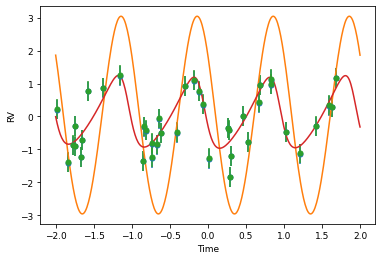

In [5]:
plot_results(like_syn) # Plot initial model
res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='Nelder-Mead' )
#res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='L-BFGS-B' )
print(res)
print(like_syn)
plot_results(like_syn) # plot best fit model

Instantiate a posterior object
===============================

In [6]:
post = radvel.posterior.Posterior(like_syn)
post.params['per1'] = radvel.Parameter(value=1)
post.params['k1'] = radvel.Parameter(value=1)
post.params['jit'].vary = True
post.priors += [radvel.prior.EccentricityPrior( 1 )]
post.priors += [radvel.prior.Gaussian( 'jit', errvel, 0.1)]
post.priors += [radvel.prior.Gaussian( 'per1', 1, 0.1)]
post.priors += [radvel.prior.Gaussian( 'tc1', 0, 0.1)]

post.priors += [radvel.prior.SecondaryEclipsePrior(1, 0.5, 0.01)]

print(post)

parameter                     value      vary
per1                              1       True
tc1                      -0.0340701       True
secosw1                    0.199714       True
sesinw1                    0.484491       True
k1                                1       True
dvdt                     -0.0183261       True
curv                      0.0260716       True
gamma                   -0.00961437       True
jit                             0.3       True

Priors
------
e1 constrained to be < 0.99
Gaussian prior on jit, mu=0.3, sigma=0.1
Gaussian prior on per1, mu=1, sigma=0.1
Gaussian prior on tc1, mu=0, sigma=0.1
secondary eclipse constraint: 0.5 +/- 0.01



Perform maximum likelihood fit on posterior
=========================================

['per1', 'tc1', 'secosw1', 'sesinw1', 'k1', 'dvdt', 'curv', 'gamma'] ['per1', 'tc1', 'secosw1', 'sesinw1', 'k1', 'dvdt', 'curv', 'gamma', 'jit'] [ 1.         -0.0340701   0.19971382  0.48449121  1.         -0.01832611
  0.02607161 -0.00961437  0.3       ]


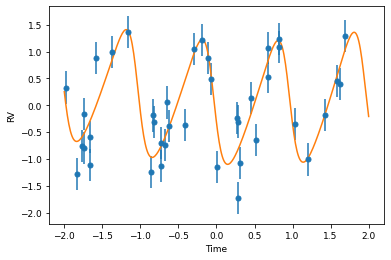

In [7]:
res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='Nelder-Mead' )
plot_results(post.likelihood)

Use mcmc to sample the posterior distribution
========================

1. use `emcee` package to run MCMC
1. corner plot visualizes parameters and correlations
1. Blue lines show the synthetic model parameters

In [8]:
df = radvel.mcmc(post,nwalkers=20,nrun=1000,savename='rawchain.h5')

8000/160000 (5.0%) steps complete; Running 12158.36 steps/s; Mean acceptance rate = 46.7%; Min Auto Factor =  22; Max Auto Relative-Change =   inf; Min Tz = 1647.5; Max G-R = 1.017
Discarding burn-in now that the chains are marginally well-mixed

160000/160000 (100.0%) steps complete; Running 12902.59 steps/s; Mean acceptance rate = 41.9%; Min Auto Factor =  50; Max Auto Relative-Change =  0.11; Min Tz = 7147.6; Max G-R = 1.004

MCMC: WARNING: chains did not pass convergence tests. They are likely not well-mixed.


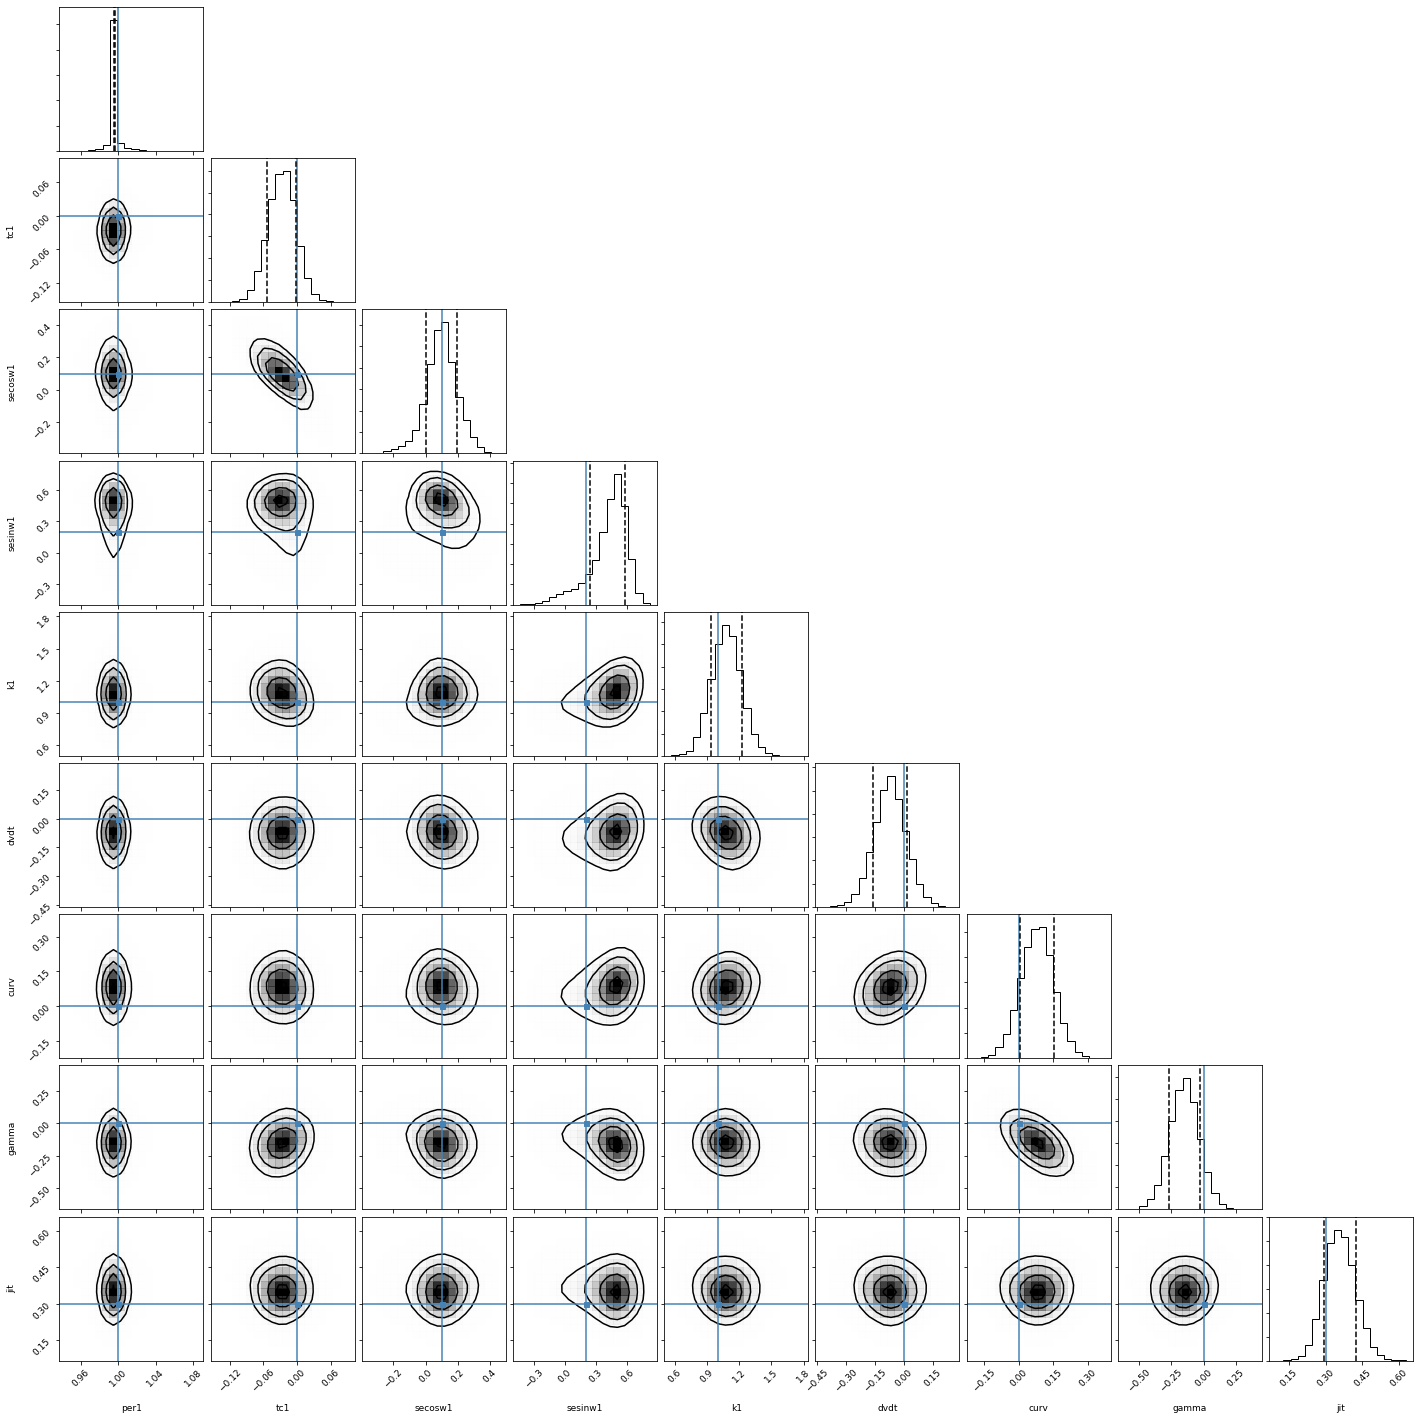

In [9]:
labels = [k for k in post.params.keys() if post.params[k].vary]



fig = corner.corner(
    df[labels],
    labels=labels,
    truths=[truths[k].value for k in labels ],
    quantiles=[0.15,0.85],
    plot_datapoints=False,
    smooth=True,
    bins=20
    )